In [31]:
import os
import numpy as np
import re

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import flax.linen as nn
import optax
from flax.training import train_state

import functools

from pathlib import Path


import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

data_dir = "./data"

print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [32]:
class MultiBasisDataLoader:
    def __init__(self, data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        lengths = [len(v) for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have the same length, got: {lengths}")

        self.data = data_dict
        self.n = lengths[0]
        self.bs = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.n, batch_size)
            if not drop_last or i + batch_size <= self.n
        ]

    def __iter__(self):
        self.order = np.arange(self.n)
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.slice_idx = 0
        return self

    def __next__(self):
        if self.slice_idx >= len(self.idx_slices):
            raise StopIteration
        s, e = self.idx_slices[self.slice_idx]
        self.slice_idx += 1
        return {k: v[self.order[s:e]] for k, v in self.data.items()}


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [33]:
data_dict = load_measurements("data/", "w_*.txt")

# 2. Create two basis key groups (regex matched)
amp_keys = [k for k in data_dict if re.fullmatch(r"^Z+$", k)]
pha_keys = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]

amp_dict = {k: data_dict[k] for k in amp_keys}
pha_dict = {k: data_dict[k] for k in pha_keys}

amp_loader           = MultiBasisDataLoader(amp_dict, batch_size=128)
pha_loader           = MultiBasisDataLoader(pha_dict, batch_size=128)

In [34]:
# iterate in parallel and print the keys
for amp_batch, pha_batch in zip(amp_loader, pha_loader):
    print(f"Amplitude batch keys: {list(amp_batch.keys())}")
    amp_key, amp_val = next(iter(amp_batch.items()))
    print(f"Amp[{amp_key}] shape: {amp_val.shape}, dtype: {amp_val.dtype}")

    print(f"Phase batch keys: {list(pha_batch.keys())}")
    
    
    #phase_Sample_count = pha_batch['ZZ'].shape[0]
    break  # just to show the first batch

Amplitude batch keys: ['ZZZZZZZZZZZZZZZ']
Amp[ZZZZZZZZZZZZZZZ] shape: (128, 15), dtype: float32
Phase batch keys: ['ZZZZZZXYZZZZZZZ', 'ZZZZZZZZZXXZZZZ', 'ZZZZZZZZZZZZZXX', 'ZZZZZZZZZZZZZXY', 'ZZZZZZZZZZXXZZZ', 'ZZZZZZZZZZZXYZZ', 'ZZZXYZZZZZZZZZZ', 'ZZZZZZZZZXYZZZZ', 'XXZZZZZZZZZZZZZ', 'ZZZZZZXXZZZZZZZ', 'ZZZZZZZZXYZZZZZ', 'ZZXYZZZZZZZZZZZ', 'ZZZZXYZZZZZZZZZ', 'ZZXXZZZZZZZZZZZ', 'ZZZZZZZXXZZZZZZ', 'ZZZZZZZZXXZZZZZ', 'ZZZZZXYZZZZZZZZ', 'ZZZZXXZZZZZZZZZ', 'ZZZZZZZZZZXYZZZ', 'ZXXZZZZZZZZZZZZ', 'ZZZZZZZZZZZZXYZ', 'ZZZZZZZXYZZZZZZ', 'ZZZZZZZZZZZXXZZ', 'XYZZZZZZZZZZZZZ', 'ZXYZZZZZZZZZZZZ', 'ZZZZZXXZZZZZZZZ', 'ZZZZZZZZZZZZXXZ', 'ZZZXXZZZZZZZZZZ']


In [56]:
from typing import Tuple, Dict, Any
from typing import Optional


class DoubleRBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1
    n_chains: int = 100

    def setup(self):
        self.W_amp = self.param("W_amp", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_amp = self.param("b_amp", nn.initializers.zeros, (self.n_visible,))
        self.c_amp = self.param("c_amp", nn.initializers.zeros, (self.n_hidden,))

        self.W_pha = self.param("W_pha", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b_pha = self.param("b_pha", nn.initializers.zeros, (self.n_visible,))
        self.c_pha = self.param("c_pha", nn.initializers.zeros, (self.n_hidden,))

    def __call__(self, data_dict: Dict[str, jnp.ndarray], aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        # access aux vars
        random_key = aux_vars.get("random_key") # we require some random key to be there
        persistent_chains = aux_vars.get("v_persistent", None)

        aux_vars = dict()

        comp_basis = 'Z' * self.n_visible
        if len(data_dict) == 1 and comp_basis in data_dict:
            data_batch = data_dict[comp_basis]
            pcd_loss, persistent_chains, random_key = self._loss_amp(data_batch, persistent_chains, random_key)

            if persistent_chains is not None:
                aux_vars["v_persistent"] = persistent_chains

            aux_vars["random_key"] = random_key

            return pcd_loss, aux_vars

        # else throw
        raise ValueError("Encountered batch of unsupported basis.")


    def _loss_amp(self, data_batch, persistent_chains, random_key):
        W = self.variables["params"]["W_amp"]
        b = self.variables["params"]["b_amp"]
        c = self.variables["params"]["c_amp"]

        if persistent_chains is None:
            random_key, random_key_bern = jax.random.split(random_key)
            chains = jax.random.bernoulli(random_key_bern, p=0.5, shape=(self.n_chains, self.n_visible))
            model_batch, random_key = self._gibbs_sample(W, b, c, chains, random_key, k=self.k)
        else:
            model_batch, random_key = self._gibbs_sample(W, b, c, persistent_chains, random_key, k=self.k)
            persistent_chains = model_batch

        model_batch = jax.lax.stop_gradient(model_batch)  # stopping gradient tracking before computing the loss

        free_energy_data = self._free_energy(W, b, c, data_batch)
        free_energy_model = self._free_energy(W, b, c, model_batch)
        pcd_loss = jnp.mean(free_energy_data) - jnp.mean(free_energy_model)

        return pcd_loss, persistent_chains, random_key

    @staticmethod
    def _free_energy(W, b, c, v):
        visible_term = jnp.dot(v, b)
        hidden_term  = jnp.sum(jax.nn.softplus(v @ W + c), axis=-1)
        free_energy = -visible_term - hidden_term
        return free_energy

    @staticmethod
    def _gibbs_step(i, state, W, b, c, T=1.0):
        v, key = state

        # splitting generates different random numbers for each step, one of them is passed on
        key, h_key, v_key = jax.random.split(key, 3)

        h_logits = (v @ W + c) / T
        h_probs = jax.nn.sigmoid(h_logits)
        h = jax.random.bernoulli(h_key, h_probs).astype(jnp.float32)

        v_logits = (h @ W.T + b) / T
        v_probs = jax.nn.sigmoid(v_logits)
        v = jax.random.bernoulli(v_key, v_probs).astype(jnp.float32)
        return v, key

    @staticmethod
    def _gibbs_sample(W, b, c, v_init, rng, k=1, T=1.0):
        # the fori_loop enables JIT compilation of loops. It basically unrolls the loop over the fixed length k.

        body_fun = lambda i, state: DoubleRBM._gibbs_step(i, state, W, b, c, T)
        v_final, key = jax.lax.fori_loop(0, k, body_fun, (v_init, rng))
        return v_final, key

    @staticmethod
    def _annealing_step(i, state, W, b, c, T_schedule):
        v, rng = state
        T = T_schedule[i]
        v_next, rng_next = DoubleRBM._gibbs_sample(W, b, c, v, rng, k=1, T=T)
        return v_next, rng_next

    @nn.nowrap
    def generate(self, n_samples: int, T_schedule: jnp.ndarray, rng: PRNGKey) -> jnp.ndarray:
        # use amplitude parameters
        W = self.variables["params"]["W_amp"]
        b = self.variables["params"]["b_amp"]
        c = self.variables["params"]["c_amp"]

        rng, init_key = jax.random.split(rng)
        v = jax.random.bernoulli(init_key, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)
        state = (v, rng)

        body_fun = lambda i, s: DoubleRBM._annealing_step(i, s, W, b, c, T_schedule)
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), body_fun, state)
        return v_final

In [57]:
class RBMTrainState(train_state.TrainState):
    """Immutable training container for optimizer, params, step, etc."""
    pass

@jax.jit
def train_step(state: RBMTrainState,
               batch: dict[str, jnp.ndarray],
               v_persistent: jnp.ndarray,
               key: PRNGKey):

    def loss_fn(params):
        return state.apply_fn({'params': params}, batch, {
            "v_persistent": v_persistent,
            "random_key": key
        })

    (loss, aux), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    new_state = state.apply_gradients(grads=grads)
    return new_state, loss, aux["v_persistent"], aux["random_key"]



In [58]:
def train_rbm(state: RBMTrainState,
              loader: MultiBasisDataLoader,
              num_epochs: int,
              rng: PRNGKey,
              pcd_reset: int = 50):

    metrics = {}

    for epoch in range(num_epochs):
        total_loss = 0.0
        batch_count = 0

        for batch_idx, data_dict in enumerate(loader):
            #print("Batch keys:", list(data_dict.keys()))  # <- DEBUG

            batch = next(iter(data_dict.values()))  # get one array from dict
            if batch_idx % pcd_reset == 0:
                rng, subkey = jax.random.split(rng)
                v_persistent = jax.random.bernoulli(subkey, p=0.5, shape=batch.shape).astype(jnp.float32)

            state, loss, v_persistent, rng = train_step(state, data_dict, v_persistent, rng)

            total_loss += loss
            batch_count += 1

        avg_loss = total_loss / batch_count
        metrics[epoch] = {"free_energy_loss": float(avg_loss)}
        print(f"Epoch [{epoch+1}/{num_epochs}] - Free Energy Loss: {avg_loss:.4f}")

    return state, metrics, rng


In [59]:
# ---- hyperparameters ----
batch_size    = 100
visible_units = 15
hidden_units  = 15
k_steps       = 1
lr            = 1e-2
num_epochs    = 100
pcd_reset     = 50

rng = PRNGKey(42)

# ---- prepare loader ----
train_loader = amp_loader

# ---- init model ----
model = DoubleRBM(n_visible=visible_units, n_hidden=hidden_units, k=k_steps)
rng, init_key = jax.random.split(rng)

dummy_batch = jnp.zeros((batch_size, visible_units), dtype=jnp.float32)
z_basis = 'Z' * visible_units  # assuming the basis is Z for the dummy batch
dummy_batch_dict = {z_basis: dummy_batch}

params = model.init(
    init_key,
    dummy_batch_dict,
    {
        "v_persistent": dummy_batch,
        "random_key": rng
    }
)["params"]

# ---- create training state ----
optimizer = optax.adam(learning_rate=lr)
state = RBMTrainState.create(apply_fn=model.apply, params=params, tx=optimizer)

# ---- train ----
state, metrics, rng = train_rbm(state, train_loader, num_epochs, rng, pcd_reset)

Epoch [1/100] - Free Energy Loss: -2.1041
Epoch [2/100] - Free Energy Loss: 0.0366
Epoch [3/100] - Free Energy Loss: -0.1805
Epoch [4/100] - Free Energy Loss: -0.2323
Epoch [5/100] - Free Energy Loss: -0.1258
Epoch [6/100] - Free Energy Loss: -0.1135
Epoch [7/100] - Free Energy Loss: -0.1529
Epoch [8/100] - Free Energy Loss: -0.1063
Epoch [9/100] - Free Energy Loss: -0.0599
Epoch [10/100] - Free Energy Loss: -0.0697
Epoch [11/100] - Free Energy Loss: -0.1033
Epoch [12/100] - Free Energy Loss: -0.0358
Epoch [13/100] - Free Energy Loss: -0.0673
Epoch [14/100] - Free Energy Loss: -0.0140
Epoch [15/100] - Free Energy Loss: -0.0762
Epoch [16/100] - Free Energy Loss: -0.0126
Epoch [17/100] - Free Energy Loss: -0.0301
Epoch [18/100] - Free Energy Loss: -0.0151
Epoch [19/100] - Free Energy Loss: -0.0180
Epoch [20/100] - Free Energy Loss: -0.0605
Epoch [21/100] - Free Energy Loss: 0.0049
Epoch [22/100] - Free Energy Loss: -0.0180
Epoch [23/100] - Free Energy Loss: -0.0091
Epoch [24/100] - Free 

Text(0, 0.5, 'Free Energy Loss')

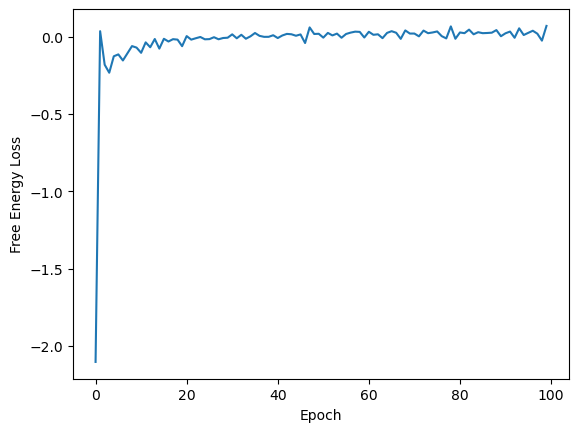

In [60]:
plt.plot([metrics[epoch]['free_energy_loss'] for epoch in metrics])
plt.xlabel("Epoch")
plt.ylabel("Free Energy Loss")

In [63]:
samples = model.apply(
    {"params": state.params},
    n_samples=10_000,
    T_schedule=jnp.ones(200) * 1.2,
    rng=rng,
    method=DoubleRBM.generate
)

rel_freq = samples.mean(0)
rel_freq

Array([0.1056    , 0.1078    , 0.1003    , 0.10879999, 0.0768    ,
       0.13      , 0.1073    , 0.1059    , 0.1135    , 0.12419999,
       0.0895    , 0.1001    , 0.1015    , 0.1136    , 0.1007    ],      dtype=float32)

In [65]:
# compare with actual frequencies from first
empirical_freq = jnp.zeros(visible_units)
num_total = 0

for batch in amp_loader:
    for arr in batch.values():
        empirical_freq += jnp.sum(arr, axis=0)
        num_total += arr.shape[0]

empirical_freq = empirical_freq / num_total
empirical_freq

Array([0.06171875, 0.06703125, 0.0665625 , 0.0659375 , 0.061875  ,
       0.06703125, 0.0646875 , 0.06875   , 0.06921875, 0.060625  ,
       0.07125   , 0.0665625 , 0.07484375, 0.0671875 , 0.06671875],      dtype=float32)

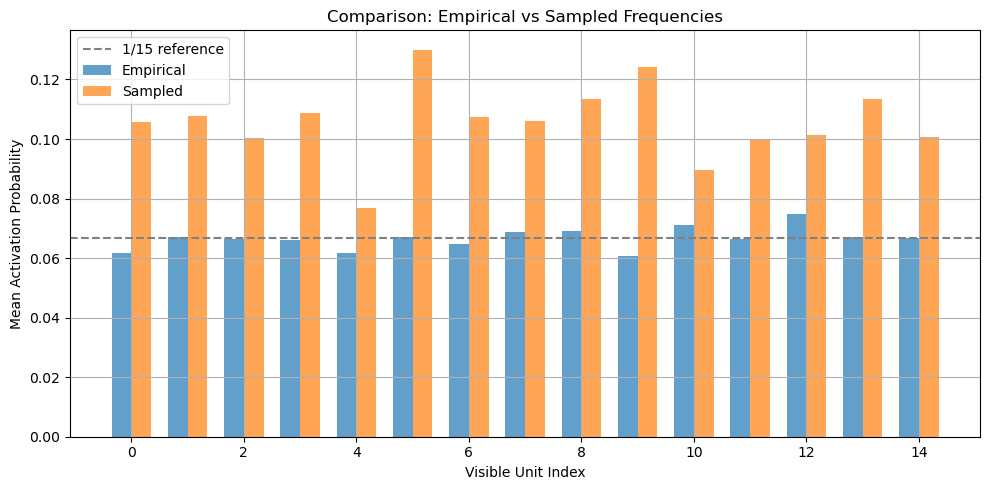

In [67]:
# Plotting comparison
plt.figure(figsize=(10, 5))
x = np.arange(visible_units)
width = 0.35

plt.bar(x - width/2, empirical_freq, width, label="Empirical", alpha=0.7)
plt.bar(x + width/2, rel_freq, width, label="Sampled", alpha=0.7)
plt.axhline(1 / visible_units, linestyle='--', color='gray', label=f'1/{visible_units} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Probability")
plt.title("Comparison: Empirical vs Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

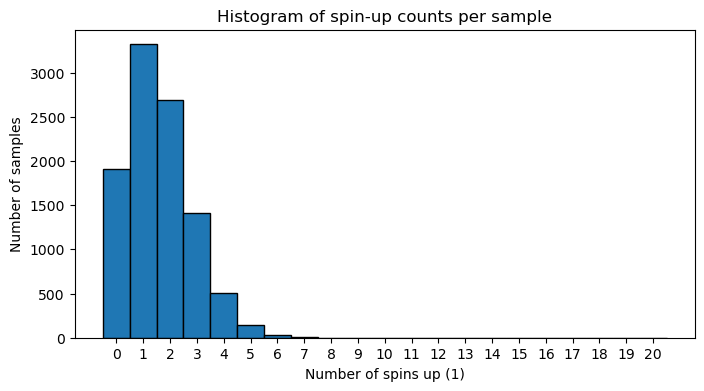

In [68]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(22), align='left', edgecolor='black')
plt.xticks(range(21))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()